# Libraries

In [1]:
import os
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from multiprocessing import Process, Lock
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
import torch as th

from drone_area_coverage import DroneEnvironment
import multi_models

# Check environment

In [2]:
# Parameters: current_agent_id, lock, map_size, drone_num, view_range, exp_name
env = DroneEnvironment(0, Lock(), (40,40), 1, 3, 'env_checker')   

# To avoid problems, we can prepare the semaphore
semaphore = {'turn': 0, 'main_thread': 0, 'reset_completed': False}
path = 'env_checker\\semaphore.npy'
np.save(path, semaphore)


check_env(env, warn=True)

del env

Thread 0 reset the environment - episode 1
Thread 0 lost after 1 steps
Thread 0 lost after 2 steps
Thread 0 reset the environment - episode 2


c:\python39\lib\site-packages\stable_baselines3\common\env_checker.py:26: UserWarning: It seems that your observation  is an image but the `dtype` of your observation_space is not `np.uint8`. If your observation is not an image, we recommend you to flatten the observation to have only a 1D vector
  warnings.warn(
c:\python39\lib\site-packages\stable_baselines3\common\env_checker.py:34: UserWarning: It seems that your observation space  is an image but the upper and lower bounds are not in [0, 255]. Because the CNN policy normalize automatically the observation you may encounter issue if the values are not in that range.
  warnings.warn(


# Main

### Hyperparameters

In [3]:
EXPERIMENT_NAME = 'experiment_1'

# ENV
MAP_SIZE = (20, 20)
DRONE_NUM = 2
VIEW_RANGE = 3

# MODEL
POLICY = 'MlpPolicy'   #'CnnPolicy'
POLICY_KWARGS = dict(
    activation_fn = th.nn.Tanh,   # th.nn.ReLU,
    net_arch=[dict(
        pi=[128, 64, 32], 
        vf=[128, 64, 32]
    )]
)
LEARNING_RATE = 0.0005
N_STEPS = 512
BATCH_SIZE = 256
EPOCHS = 10
GAMMA = 0.999
GAE_LAMBDA = 0.98
CLIP_RANGE = 0.2
ENT_COEF = 0.01
VERBOSE = 0


# LEARNING
LEARNING_STEPS = 10000


# Create the dirs
exp_dir = EXPERIMENT_NAME
models_dir = EXPERIMENT_NAME + '/models'
os.makedirs(exp_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

### PPO in Threads

In [4]:
# To avoid problems, we can prepare the semaphore
semaphore = {'turn': 0, 'main_thread': 0, 'reset_completed': False}
path = EXPERIMENT_NAME + '\\semaphore.npy'
np.save(path, semaphore)

In [5]:
# Create a list of processes
processes = []
lock = Lock()
for i in range(DRONE_NUM): 
    processes.append(Process(target=multi_models.run_agent, args=(
        i, lock, MAP_SIZE, DRONE_NUM, VIEW_RANGE, POLICY, LEARNING_RATE, N_STEPS, BATCH_SIZE, EPOCHS, 
        GAMMA, GAE_LAMBDA, CLIP_RANGE, ENT_COEF, POLICY_KWARGS, VERBOSE, LEARNING_STEPS, EXPERIMENT_NAME
    )))
    
# Start each of the processes
for p in processes:
    p.start()
    
# Join the processes (make current thread not finishes until subthreads finish)
for p in processes:
    p.join()

In [ ]:
# Command for Tensorboard visualization: 
# > tensorboard --logdir <PATH TO TENSORBORAD DIR INSIDE EXPERIMENT DIR>

### Test

<IPython.core.display.Javascript object>


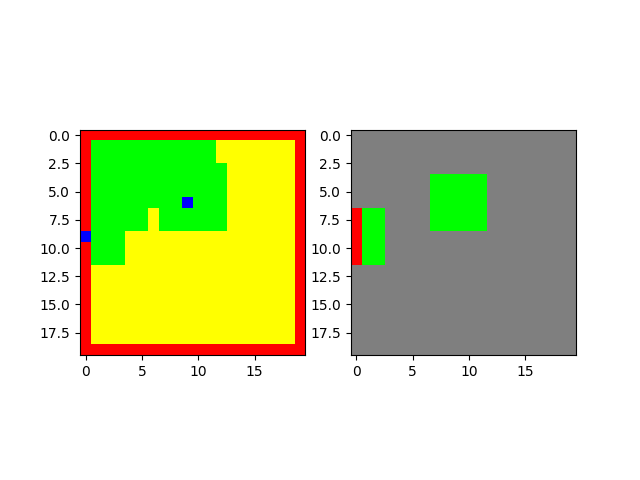

Thread 0 reset the environment - episode 1
Thread 0 lost after 16 steps
Total Reward: -39.0
Total steps: 16
Percentage of covered cells: 0.3117283950617284
Covered cells per step: 6.3125


In [7]:
EXPERIMENT_NAME = 'experiment_1'

# ENV
MAP_SIZE = (20, 20)
DRONE_NUM = 2
VIEW_RANGE = 3


# The MANAGER agent will be executed here in this thread, as the main thread

# To avoid problems, we can prepare the semaphore
semaphore = {'turn': 0, 'main_thread': 0, 'reset_completed': False}
path = EXPERIMENT_NAME + '\\semaphore.npy'
np.save(path, semaphore)

# Create a list of processes
processes = []
lock = Lock()
for i in range(1, DRONE_NUM):  
    processes.append(Process(target=multi_models.test_agent, args=(
        i, lock, MAP_SIZE, DRONE_NUM, VIEW_RANGE, EXPERIMENT_NAME
    )))
    
# Start each of the processes
for p in processes:
    p.start()
    

# path_model = EXPERIMENT_NAME + '\\models\\agent' + str(0)
path_model = EXPERIMENT_NAME + '\\models\\best_agent' + str(0)
model = PPO.load(path_model)

env = DroneEnvironment(0, lock, MAP_SIZE, DRONE_NUM, VIEW_RANGE, EXPERIMENT_NAME)
total_reward = 0

plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

obs = env.reset()
while True:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)
    total_reward += reward

    ax1.clear()
    ax1.imshow(env.get_full_obs())
    ax2.clear()
    ax2.imshow(env.get_joint_obs())
    
    
    fig.canvas.draw()
    
    if done:
        break


steps = env.getSteps()
coveredCellRate = env.getObsevedCellRate()
coveredCellStep = env.getObservedTargetCells()/env.getSteps()


print(f"Total Reward: {total_reward}")
print(f"Total steps: {steps}")
print(f"Percentage of covered cells: {coveredCellRate}")
print(f"Covered cells per step: {coveredCellStep}")

### Mean reward in 100 episodes

In [ ]:
EXPERIMENT_NAME = 'experiment_1'

# ENV
MAP_SIZE = (20, 20)
DRONE_NUM = 2
VIEW_RANGE = 3

# Number of episodes
episodes = 100


# To avoid problems, we can prepare the semaphore
semaphore = {'turn': 0, 'main_thread': 0, 'reset_completed': False}
path = EXPERIMENT_NAME + '\\semaphore.npy'
np.save(path, semaphore)
    
# Create a list of processes
processes = []
lock = Lock()
for i in range(1, DRONE_NUM):  
    processes.append(Process(target=multi_models.test_agent_mean, args=(
        i, lock, MAP_SIZE, DRONE_NUM, VIEW_RANGE, EXPERIMENT_NAME, episodes
    )))
    
# Start each of the processes
for p in processes:
    p.start()
    
    
#path_model = EXPERIMENT_NAME + '\\models\\agent' + str(0)
path_model = EXPERIMENT_NAME + '\\models\\best_agent' + str(0)
model = PPO.load(path_model)

env = DroneEnvironment(0, lock, MAP_SIZE, DRONE_NUM, VIEW_RANGE, EXPERIMENT_NAME)


rewards = np.empty(episodes)
steps = np.empty(episodes)
coveredCellRates = np.empty(episodes)
coveredCellSteps = np.empty(episodes)

for i in range(episodes):
    ep_reward = 0
    obs = env.reset()
    while True:   
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        ep_reward += reward
        if done:
            rewards[i] = ep_reward
            break
            
    steps[i] = env.getSteps()
    coveredCellRates[i] = env.getObsevedCellRate()
    coveredCellSteps[i] = env.getObservedTargetCells()/env.getSteps()



print(f"\n\nMean reward: {rewards.mean()}")
print(f"Mean steps: {steps.mean()}")
print(f"Mean covered cells percentage: {coveredCellRates.mean()}")
print(f"Mean covered cells per step: {coveredCellSteps.mean()}")

plt.ion()
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax1.hist(rewards, bins=25)
#ax1.title.set_text('Rewards hist.')
ax2 = fig.add_subplot(222)
ax2.hist(steps, bins=25)
#ax2.title.set_text('Steps hist.')
ax3 = fig.add_subplot(223)
ax3.hist(coveredCellRates, bins=25, range=(0,1))
#ax3.title.set_text('Covered cells percentage hist.')
ax4 = fig.add_subplot(224)
ax4.hist(coveredCellSteps, bins=25, range=(0,1))
#ax4.title.set_text('Covered cells per step hist.')
plt.show()

### Extend the learning, continuing it

In [ ]:
OLD_MODEL_PATH = 'experiment_1/models/best_agent0.zip'
EXPERIMENT_NAME = 'experiment_1_continued'

# ENV
MAP_SIZE = (20, 20)
DRONE_NUM = 2
VIEW_RANGE = 3

# NEW HYPERPARAMETERS FOR THE MODEL
CUSTOM_OBJECTS = {
    'tensorboard_log': EXPERIMENT_NAME,
    'learning_rate': 0.0003,
    'n_steps': 1024,
    'batch_size': 512
#     'n_epochs': 10,
#     'gamma': 0.999,
#     'gae_lambda': 0.98,
#     'clip_range': 0.2,
#     'ent_coef': 0.01
}


# LEARNING
LEARNING_STEPS = 20000


# Create the dirs
exp_dir = EXPERIMENT_NAME
models_dir = EXPERIMENT_NAME + '/models'
os.makedirs(exp_dir, exist_ok=True)
os.makedirs(models_dir, exist_ok=True)

In [ ]:
# To avoid problems, we can prepare the semaphore
semaphore = {'turn': 0, 'main_thread': 0, 'reset_completed': False}
path = EXPERIMENT_NAME + '\\semaphore.npy'
np.save(path, semaphore)

# Create a list of processes
processes = []
lock = Lock()
for i in range(DRONE_NUM): 
    processes.append(Process(target=multi_models.continue_agent, args=(
        i, lock, MAP_SIZE, DRONE_NUM, VIEW_RANGE, CUSTOM_OBJECTS, LEARNING_STEPS, EXPERIMENT_NAME, OLD_MODEL_PATH
    )))
    
# Start each of the processes
for p in processes:
    p.start()
    
# Join the processes (make current thread not finishes until subthreads finish)
for p in processes:
    p.join()